In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from astropy.table import Table
import os
import pymc as pm
import pytensor
import pytensor.tensor as tt
import arviz
import corner

from import_templates import prep_scale_templates
#from VIRUS_target_prep import from_example_h5file #if you want to import VIRUS data from its h5file
from features_to_evaluate import avg_point_feature, avg_point_feature_err, slope_feature, slope_feature_err, photometry_feature
from least_squares_fitter import least_squares_fit_function
from pymc_fitter import pymc_NUTS_fitting

In this notebook, we use nuts-for-ysos with an example spectrum from VIRUS, provided in a fits file (2MASS_J03285101+3118184.fits). There are some rules you should adhere to, when inputting a YSO spectrum into nuts-for-ysos:
1. The spectrum must only occupy wavelengths between 3300A and 10190A
2. It needs to have a wavelength array with Δλ of at least 0.3 Angstroms.
3. The spectrum must have a separate uncertainty array associated with it.
4. You need to know the distance to the YSO (though it can be either with or without uncertainty)

In the cell below, we define a few things:

1. The name for our YSO (in this case 'test_YSO')
2. The wavelength array of our spectrum, called 'def_wave_data'
3. The average resolution of our spectrum (so that the Class III template resolution can be matched to it)
4. The distance to the YSO in parsecs as:
    distance_info = [mean distance, lower bound , upper bound]
but if you don't have upper and lower bounds, you can also just set distance_info to be a scalar number in parsecs.
5. The Rv used in the extinction law (Cardelli et al 1989). We set it to 3.1, which is the default in nuts-for-ysos anyways.
6. The spectrum array, called YSO
7. The spectrum's uncertainty, called YSO_err

We provide example VIRUS YSO spectra, which are are contained in .fits files. These spectra are the exact same ones used in [insert paper].
Refer to the file 'VIRUS_target_prep.py' to see how you can quickly retrieve a VIRUS spectrum from its h5 file. The from_example_h5file() function allow you to toggle whether or not the VIRUS spectrum gets rescaled by its PanSTARRS gmag or is normalized, as was done in [insert paper].

In [2]:
name = 'test_YSO'
def_wave_data = np.arange(3470, 5542, 2) #angstroms
mean_resolution = 750
distance_info = [303.156647,297.884674,307.583466] #parsecs
Rv = 3.1

data_table = Table.read('example_VIRUS_spectra/2MASS_J03285101+3118184.fits')
YSO, YSO_err = data_table['flux (erg/s/cm2)'], data_table['error']
#YSO, YSO_err = from_example_h5file(h5filename, h5index) #if you want to import VIRUS data directly from its h5file instead

Here we will plot the YSO spectrum for which we will attempt to fit the model.

Text(0.5, 1.0, 'test_YSO')

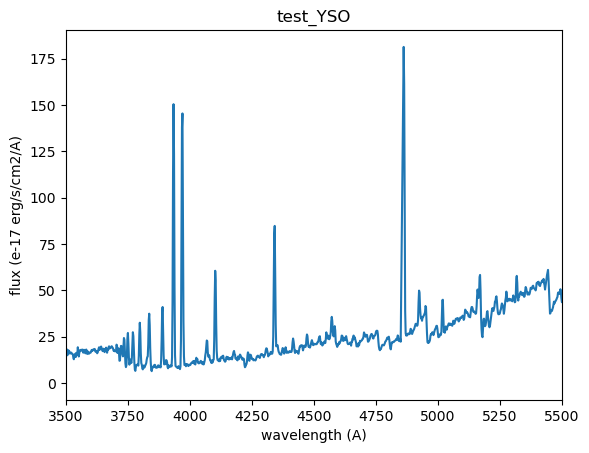

In [4]:
plt.plot(def_wave_data, YSO)
plt.xlim(3500,5500)
plt.xlabel('wavelength (A)')
plt.ylabel('flux (e-17 erg/s/cm2/A)')
plt.title(name)

In the next cell, we create the set of class III YSO template spectra from X-Shooter, that are used to represent the photospheres of accreting YSOs. The set spans from Teff = 2400K to 5770K.
The function prep_scale_templates() outputs arrays for the template Teff, luminosity (as in log(L/Lsun)), the wavelength array, and the flux. The purpose of this function is to make the raw X-shooter templates match the resolution of your YSO spectrum.

In [5]:
template_Teffs, template_lums, def_wave_model, templates_scaled = prep_scale_templates(def_wave_data, mean_resolution)

In fitting the YSO model to the data, we actually do not fit to the entire spectrum. In brief, this is because the model is not meant to replicate the emission lines in the YSO spectrum, only the continuum. We can choose what 'features' in the spectrum we would like to fit for. By default, nuts-for-ysos uses the features in Table 4 of [insert paper].
There are three types used by default: 
1. 'point' is an average value over a small wavelength range (eg. 20A).
2. 'slope' is one 'point' subtracted from another.
3. 'photometry' is the AB magnitude you obtain by convolving the spectrum with a specified filter (eg. PanSTARRS g, r, or i)

These three types each have respective functions that we imported from features_to_evaluate.py. The functions all take a certain input:
1. avg_point_feature takes a wavelength array, left_bound, right_bound, and spectrum array, and outputs the mean of the spectrum between left_bound and right_bound.
2. slope_feature takes a wavelength array, left_bound_y1, right_bound_y1, left_bound_y2, right_bound_y2 (bounds for points y1 and y2), and spectrum array. The output is y2-y1.
3. photometry_feature takes a wavelength array, a filter array, and spectrum array and outputs the apparent magnitude in that filter. 

In the cell below, we start by defining the PanSTARRRS r ang i filters, read from the provided files 'psr_filter_curve.csv' and 'psi_filter_curve.csv'. We then set the types and bounds for each feature, and give them a name.

Finally, we determine the values of these features for our YSO spectrum. 
Note that for our particular example, we do not actually calculate the 'photometry' features for the inputted YSO spectrum. Instead, we set the value to just be the official PanSTARRS r and i magnitudes. We *will* calculate 'rmag' and 'imag' for the model. But for the VIRUS data itself, the wavelength array only goes up to 5500A and is therefore not covered by the rmag and imag filters. We conservatively set the uncertainty on rmag and imag to each be 0.2 (see [insert paper] for explanation on this)

Ultimately, you can choose whatever features you want, as long as you follow the same framework used here. You can choose the types and bounds of the features simply by changing the values in the cell below. If desired, you can even create entirely new features by adding a new function to the features_to_evaluate.py file and adding them into least_squares_fitter.py and pymc_fitter.py.

In [6]:
#Pan-STARRS filters
ps2r_file = Table.read('psr_filter_curve.csv')
ps2r_wave=ps2r_file ['wavelength (A)']
ps2r_val=ps2r_file ['transmission']
ps2r_wave = np.array(ps2r_wave)
ps2r_val = np.array(ps2r_val)
filtr = np.interp(def_wave_model, ps2r_wave, ps2r_val, left=0.0, right=0.0)
ps2i_file = Table.read('psi_filter_curve.csv')
ps2i_wave=ps2i_file ['wavelength (A)']
ps2i_val=ps2i_file ['transmission']
ps2i_wave = np.array(ps2i_wave)
ps2i_val = np.array(ps2i_val)
filti = np.interp(def_wave_model, ps2i_wave, ps2i_val, left=0.0, right=0.0)

feature_types = ['slope', 'point', 'point', 'point', 'slope', 'point', 'point', 'point', 'slope', 'photometry', 'photometry']
feature_bounds = [[3504.0, 3524.0, 3580.0, 3600.0], [3580.0, 3620.0], [3850.0, 3870.0], [4000.0, 4030.0], [3980.0, 4020.0, 4770.0, 4820.0], [4590.0, 4624.0], [5090.0, 5130.0], [5460.0, 5490.0], [5060.0, 5100.0, 5390.0, 5424.0], filtr, filti]
feature_names = ['balmer_slope', 'balmer_val', 'balmer_val_2', 'purple_val', 'paschen_slope', 'paschen_val', 'optical_val', 'optical_val_2', 'optical_slope_2', 'rmag', 'imag']

YSO_spectrum_features = []
YSO_spectrum_features_errs = []
for f in range(0, len(feature_types)):
    if feature_types[f] == 'ratio':
        YSO_spectrum_features.append(ratio_feature(def_wave_data, feature_bounds[f][0], feature_bounds[f][1], feature_bounds[f][2], feature_bounds[f][3], YSO))
        YSO_spectrum_features_errs.append(ratio_feature_err(def_wave_data, feature_bounds[f][0], feature_bounds[f][1], feature_bounds[f][2], feature_bounds[f][3], YSO, YSO_err))
    if feature_types[f] == 'point':
        YSO_spectrum_features.append(avg_point_feature(def_wave_data, feature_bounds[f][0], feature_bounds[f][1], YSO))
        YSO_spectrum_features_errs.append(avg_point_feature_err(def_wave_data, feature_bounds[f][0], feature_bounds[f][1], YSO, YSO_err))
    if feature_types[f] == 'slope':
        YSO_spectrum_features.append(slope_feature(def_wave_data, feature_bounds[f][0], feature_bounds[f][1], feature_bounds[f][2], feature_bounds[f][3], YSO))
        YSO_spectrum_features_errs.append(slope_feature_err(def_wave_data, feature_bounds[f][0], feature_bounds[f][1], feature_bounds[f][2], feature_bounds[f][3], YSO, YSO_err))
    #if feature_types[f] == 'photometry':
        #we are not going to be taking photometry from the spectrum itself, instead we use PanSTARRS (see below)

#from PanSTARRS data
ps_rmag_target = 16.0739
ps_imag_target = 14.6527
YSO_spectrum_features.append(ps_rmag_target)
YSO_spectrum_features_errs.append(0.2)
YSO_spectrum_features.append(ps_imag_target)
YSO_spectrum_features_errs.append(0.2)

In [7]:
#let's make a table of the features to summarize for the user
feature_formulae = []
for i in range(0, len(feature_types)):
    if feature_types[i]=='point':
        formula = 'avg λ'+str(feature_bounds[i][0])+':'+str(feature_bounds[i][1])
    if feature_types[i]=='slope':
        formula = 'avg λ'+str(feature_bounds[i][2])+':'+str(feature_bounds[i][3]) + ' - ' + 'avg λ'+str(feature_bounds[i][0])+':'+str(feature_bounds[i][1])
    if feature_types[i]=='photometry':
        formula = 'filter (eg. PanSTARRS)'
    feature_formulae.append(formula)

feature_table = Table([feature_names, feature_types, feature_formulae, YSO_spectrum_features, YSO_spectrum_features_errs], names=('Feature Name', 'Type', 'Formula', 'YSO Value', 'YSO uncert'))
feature_table

Feature Name,Type,Formula,YSO Value,YSO uncert
str15,str10,str39,float64,float64
balmer_slope,slope,avg λ3580.0:3600.0 - avg λ3504.0:3524.0,-0.06393243399901039,1.1548966825408866
balmer_val,point,avg λ3580.0:3620.0,17.029309708417426,0.5566121795491262
balmer_val_2,point,avg λ3850.0:3870.0,8.784745367741177,0.4423958396438725
purple_val,point,avg λ4000.0:4030.0,11.089055866496096,0.4431903631767283
paschen_slope,slope,avg λ4770.0:4820.0 - avg λ3980.0:4020.0,11.276038479944427,0.6337881101417695
paschen_val,point,avg λ4590.0:4624.0,22.42756305690149,0.6727321685219628
optical_val,point,avg λ5090.0:5130.0,36.52986032697725,0.9477288359122777
optical_val_2,point,avg λ5460.0:5490.0,44.233546529347535,1.3062796381108985
optical_slope_2,slope,avg λ5390.0:5424.0 - avg λ5060.0:5100.0,18.936686346185375,1.6898574268640265


The goal of nuts-for-ysos is to use the NUTS sampler within PyMC. But the sampler requires a starting point. We find our starting point for the parameters using the least_squares_fit_function() as done below. 
By default, least_squares_fit_function() plots the result of the fit. It's useful to see the plot so that you can note whether the result looks reasonable or whether there might be an issue in your input somewhere. The PyMC portion can take a while to run! So it is better to address issues at this stage. If you want to skip the plot, include plot=False at the end of the least_squares_fit_function() arguments.

performing initial least squares fit


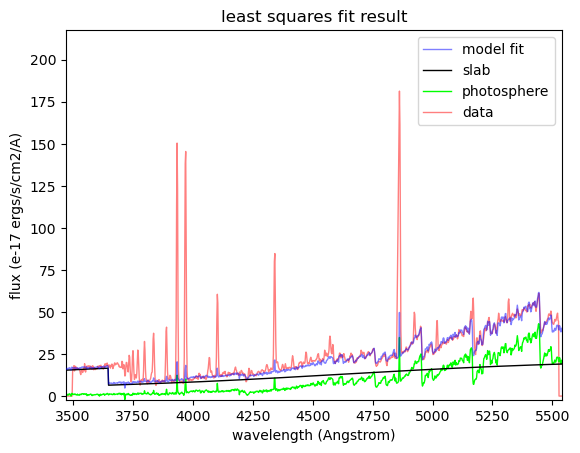

In [8]:
init_params = least_squares_fit_function(def_wave_data, mean_resolution, YSO, YSO_spectrum_features, YSO_spectrum_features_errs, feature_types, feature_bounds)

In the cell below, we finally carry out the model fitting with PyMC. Once NUTS is initialized, you'll see a progress bar to see how far along the sampling process is. Once the sampling is complete, the PyMC trace (which is, by default, returned as an ArviZ InferenceData object) is stored in a 'NetCDF' file.
You can find more information on PyMC here: https://www.pymc.io/welcome.html

In [9]:
target_accept_set = 0.99
length = 2000
chains = 16
cores = 16 #the number of cores will depend on your system

trace = pymc_NUTS_fitting(def_wave_data, mean_resolution, np.array(YSO_spectrum_features), np.array(YSO_spectrum_features_errs), feature_types, feature_bounds, distance_info, name, np.array(init_params), target_accept_set, length, chains, cores)

initializing PyMC fitter


/tmp/ipykernel_34968/3798862644.py:6: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.
  trace = pymc_NUTS_fitting(def_wave_data, mean_resolution, np.array(YSO_spectrum_features), np.array(YSO_spectrum_features_errs), feature_types, feature_bounds, distance_info, name, np.array(init_params), target_accept_set, length, chains, cores)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [T, n_e_log, tau_0, Kslab_1e6, Kphot_1e6, Av, Av_grid_uncert, Teff, Teff_grid_uncert, Lum_grid_uncert, distance]


Sampling 16 chains for 1_000 tune and 2_000 draw iterations (16_000 + 32_000 draws total) took 11247 seconds.


In [10]:
#if you need to retrieve the trace from its NetCDF file later:
#trace = arviz.from_netcdf(name+'_tracefile')

There are many ways to work with an InferenceData object; see https://python.arviz.org/en/latest/getting_started/WorkingWithInferenceData.html for more details.
For example, the summary() function in ArviZ derives useful results from the trace, such as the averages and standard deviations for each parameter.

In [11]:
summary = arviz.summary(trace)
print(summary)
summaryfile = open(name+ '_summary.txt', 'w')
summaryfile.write(str(summary))
summaryfile.close()

                                     mean        sd    hdi_3%    hdi_97%  \
T                               11709.330  2010.731  8144.204  14994.514   
n_e_log                            13.407     1.734    10.461     15.999   
tau_0                               3.218     1.029     1.288      5.000   
Kslab_1e6                          12.721    43.671     1.548     25.564   
Kphot_1e6                          80.290    24.055    39.155    124.869   
Av                                  2.118     0.303     1.550      2.692   
Av_grid_uncert                      0.125     0.096     0.000      0.299   
Teff                             3109.372   100.616  2917.925   3291.513   
Teff_grid_uncert                   -0.173    87.844  -167.477    159.783   
Lum_grid_uncert                     0.001     0.193    -0.357      0.368   
distance                          302.710     4.976   293.267    311.843   
Kslab_1e6_log                       0.871     0.320     0.366      1.467   
Kphot_1e6_lo

A useful visualizing plot can also be made directly from the trace, through the ArviZ plot_trace() function. The 'corner' package also lets us easily make corner plots directly from the trace.

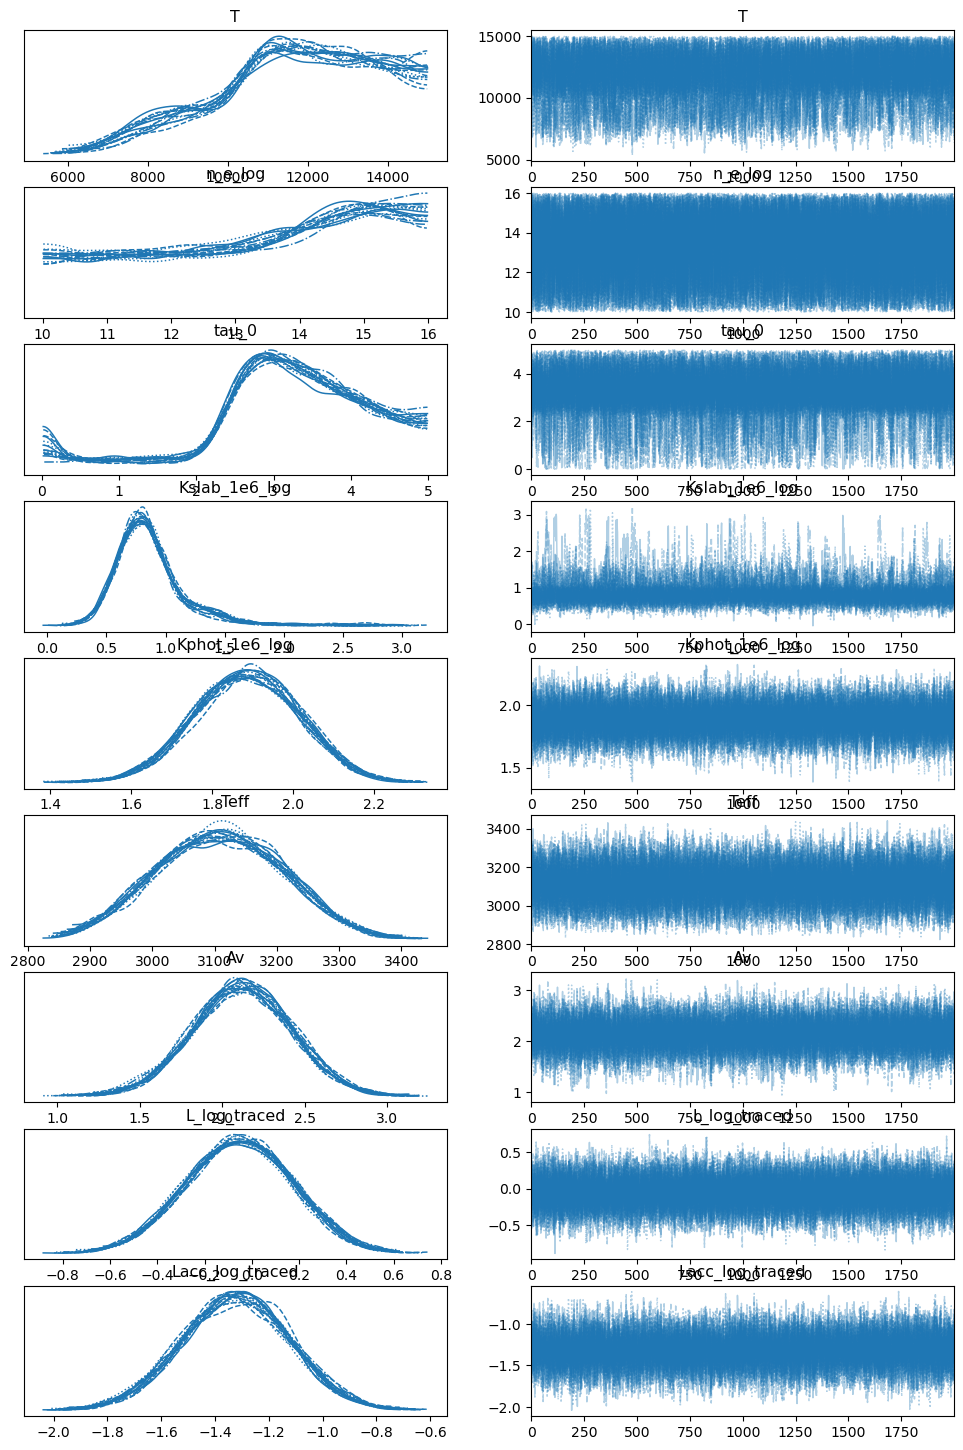

In [12]:
arviz.plot_trace(trace, var_names = ['T', 'n_e_log', 'tau_0', 'Kslab_1e6_log', 'Kphot_1e6_log', 'Teff', 'Av', 'L_log_traced', 'Lacc_log_traced'])
plt.savefig(name+'_traceplot')

One can also use packages like 'corner' to make corner plots from the trace, like so:

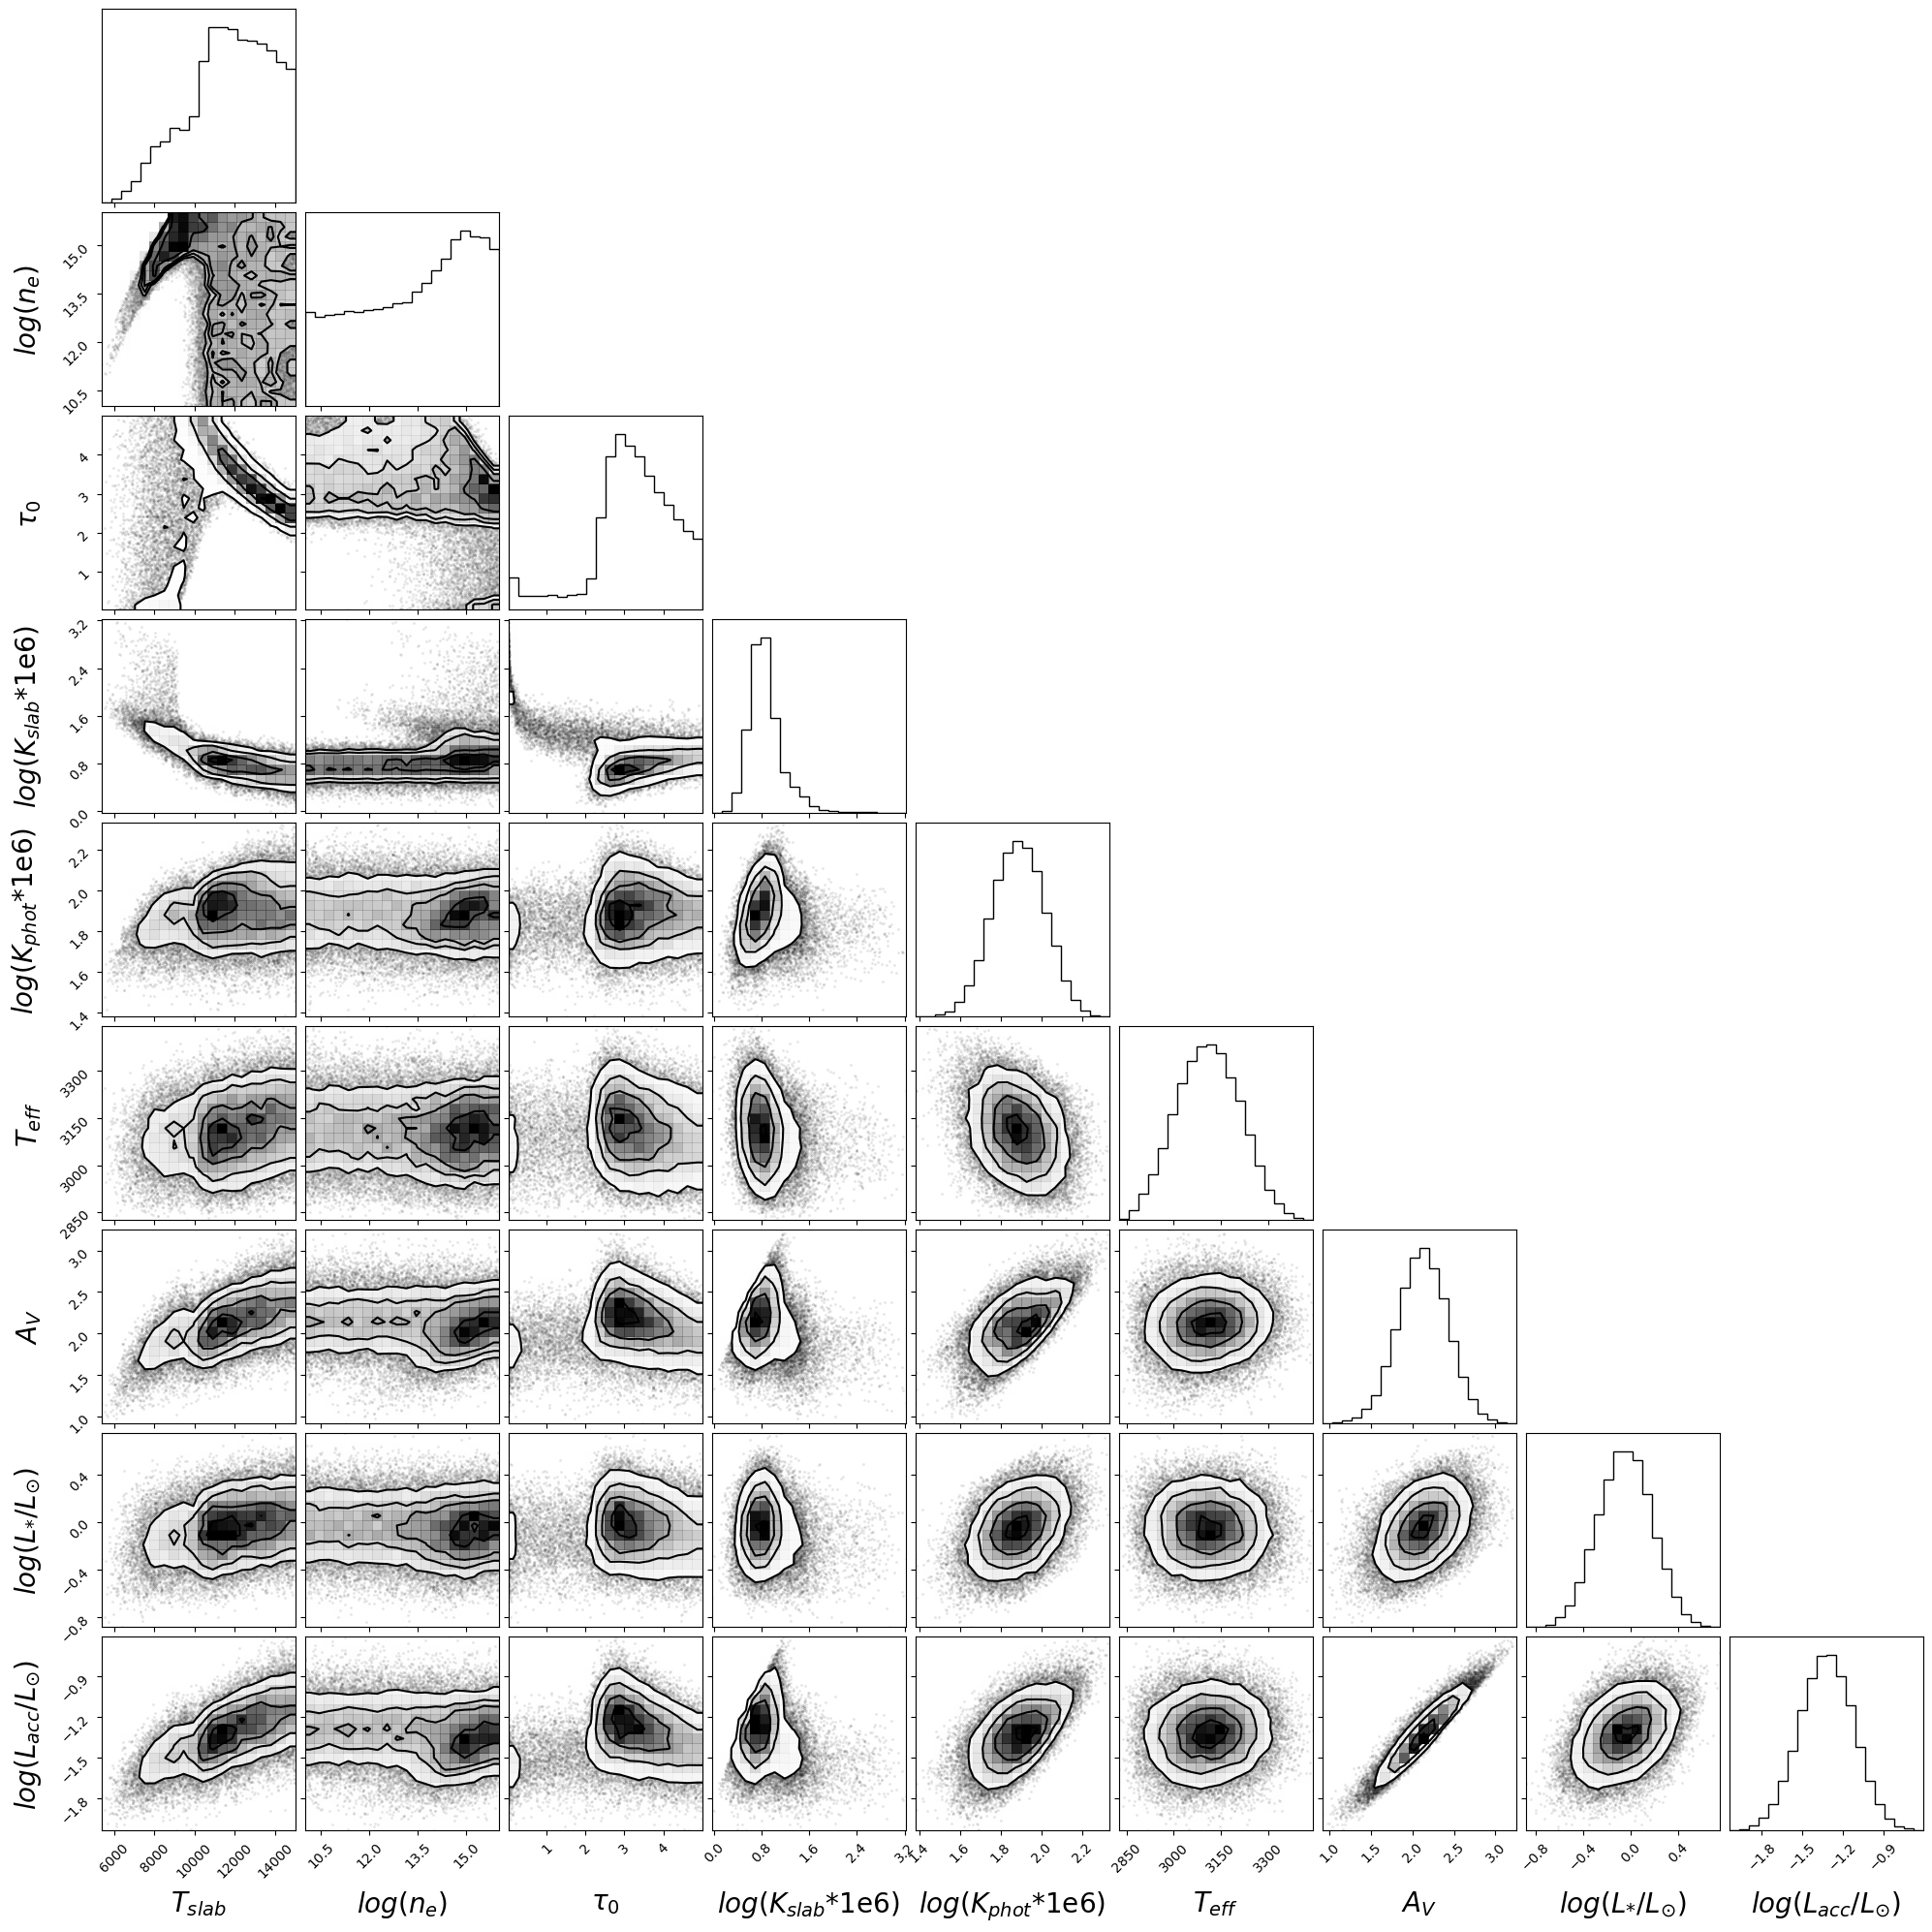

In [13]:
figure = corner.corner(trace, var_names = ['T', 'n_e_log', 'tau_0', 'Kslab_1e6_log', 'Kphot_1e6_log', 'Teff', 'Av', 'L_log_traced', 'Lacc_log_traced'], labels = [r'$T_{slab}$', r'$log(n_{e})$', r'$τ_0$', r'$log(K_{slab}$*1e6)', r'$log(K_{phot}$*1e6)', r'$T_{eff}$', r'$A_{V}$', r'$log(L_{*}/L_{\odot})$', r'$log(L_{acc}/L_{\odot})$'], label_kwargs={"fontsize": 20})
plt.savefig(name+'_corner')
plt.show()

If the trace has a significant level of autocorrelation, we need to thin out the trace to mitigate the autocorrelation (ie. use only every nth value of the trace). To learn more about autocorrelation and other aspects of the trace, see https://pymcmc.readthedocs.io/en/latest/modelchecking.html. To check if thinning=20 is enough for your trace, you can use the plot_autocorr() function in ArviZ. Below we plot only for the first 3 chains, but you should check all of your chains.

array([[<AxesSubplot: title={'center': 'T\n0'}>,
        <AxesSubplot: title={'center': 'T\n1'}>,
        <AxesSubplot: title={'center': 'T\n2'}>],
       [<AxesSubplot: title={'center': 'n_e_log\n0'}>,
        <AxesSubplot: title={'center': 'n_e_log\n1'}>,
        <AxesSubplot: title={'center': 'n_e_log\n2'}>],
       [<AxesSubplot: title={'center': 'tau_0\n0'}>,
        <AxesSubplot: title={'center': 'tau_0\n1'}>,
        <AxesSubplot: title={'center': 'tau_0\n2'}>],
       [<AxesSubplot: title={'center': 'Kslab_1e6_log\n0'}>,
        <AxesSubplot: title={'center': 'Kslab_1e6_log\n1'}>,
        <AxesSubplot: title={'center': 'Kslab_1e6_log\n2'}>],
       [<AxesSubplot: title={'center': 'Kphot_1e6_log\n0'}>,
        <AxesSubplot: title={'center': 'Kphot_1e6_log\n1'}>,
        <AxesSubplot: title={'center': 'Kphot_1e6_log\n2'}>],
       [<AxesSubplot: title={'center': 'Teff\n0'}>,
        <AxesSubplot: title={'center': 'Teff\n1'}>,
        <AxesSubplot: title={'center': 'Teff\n2'}>],
 

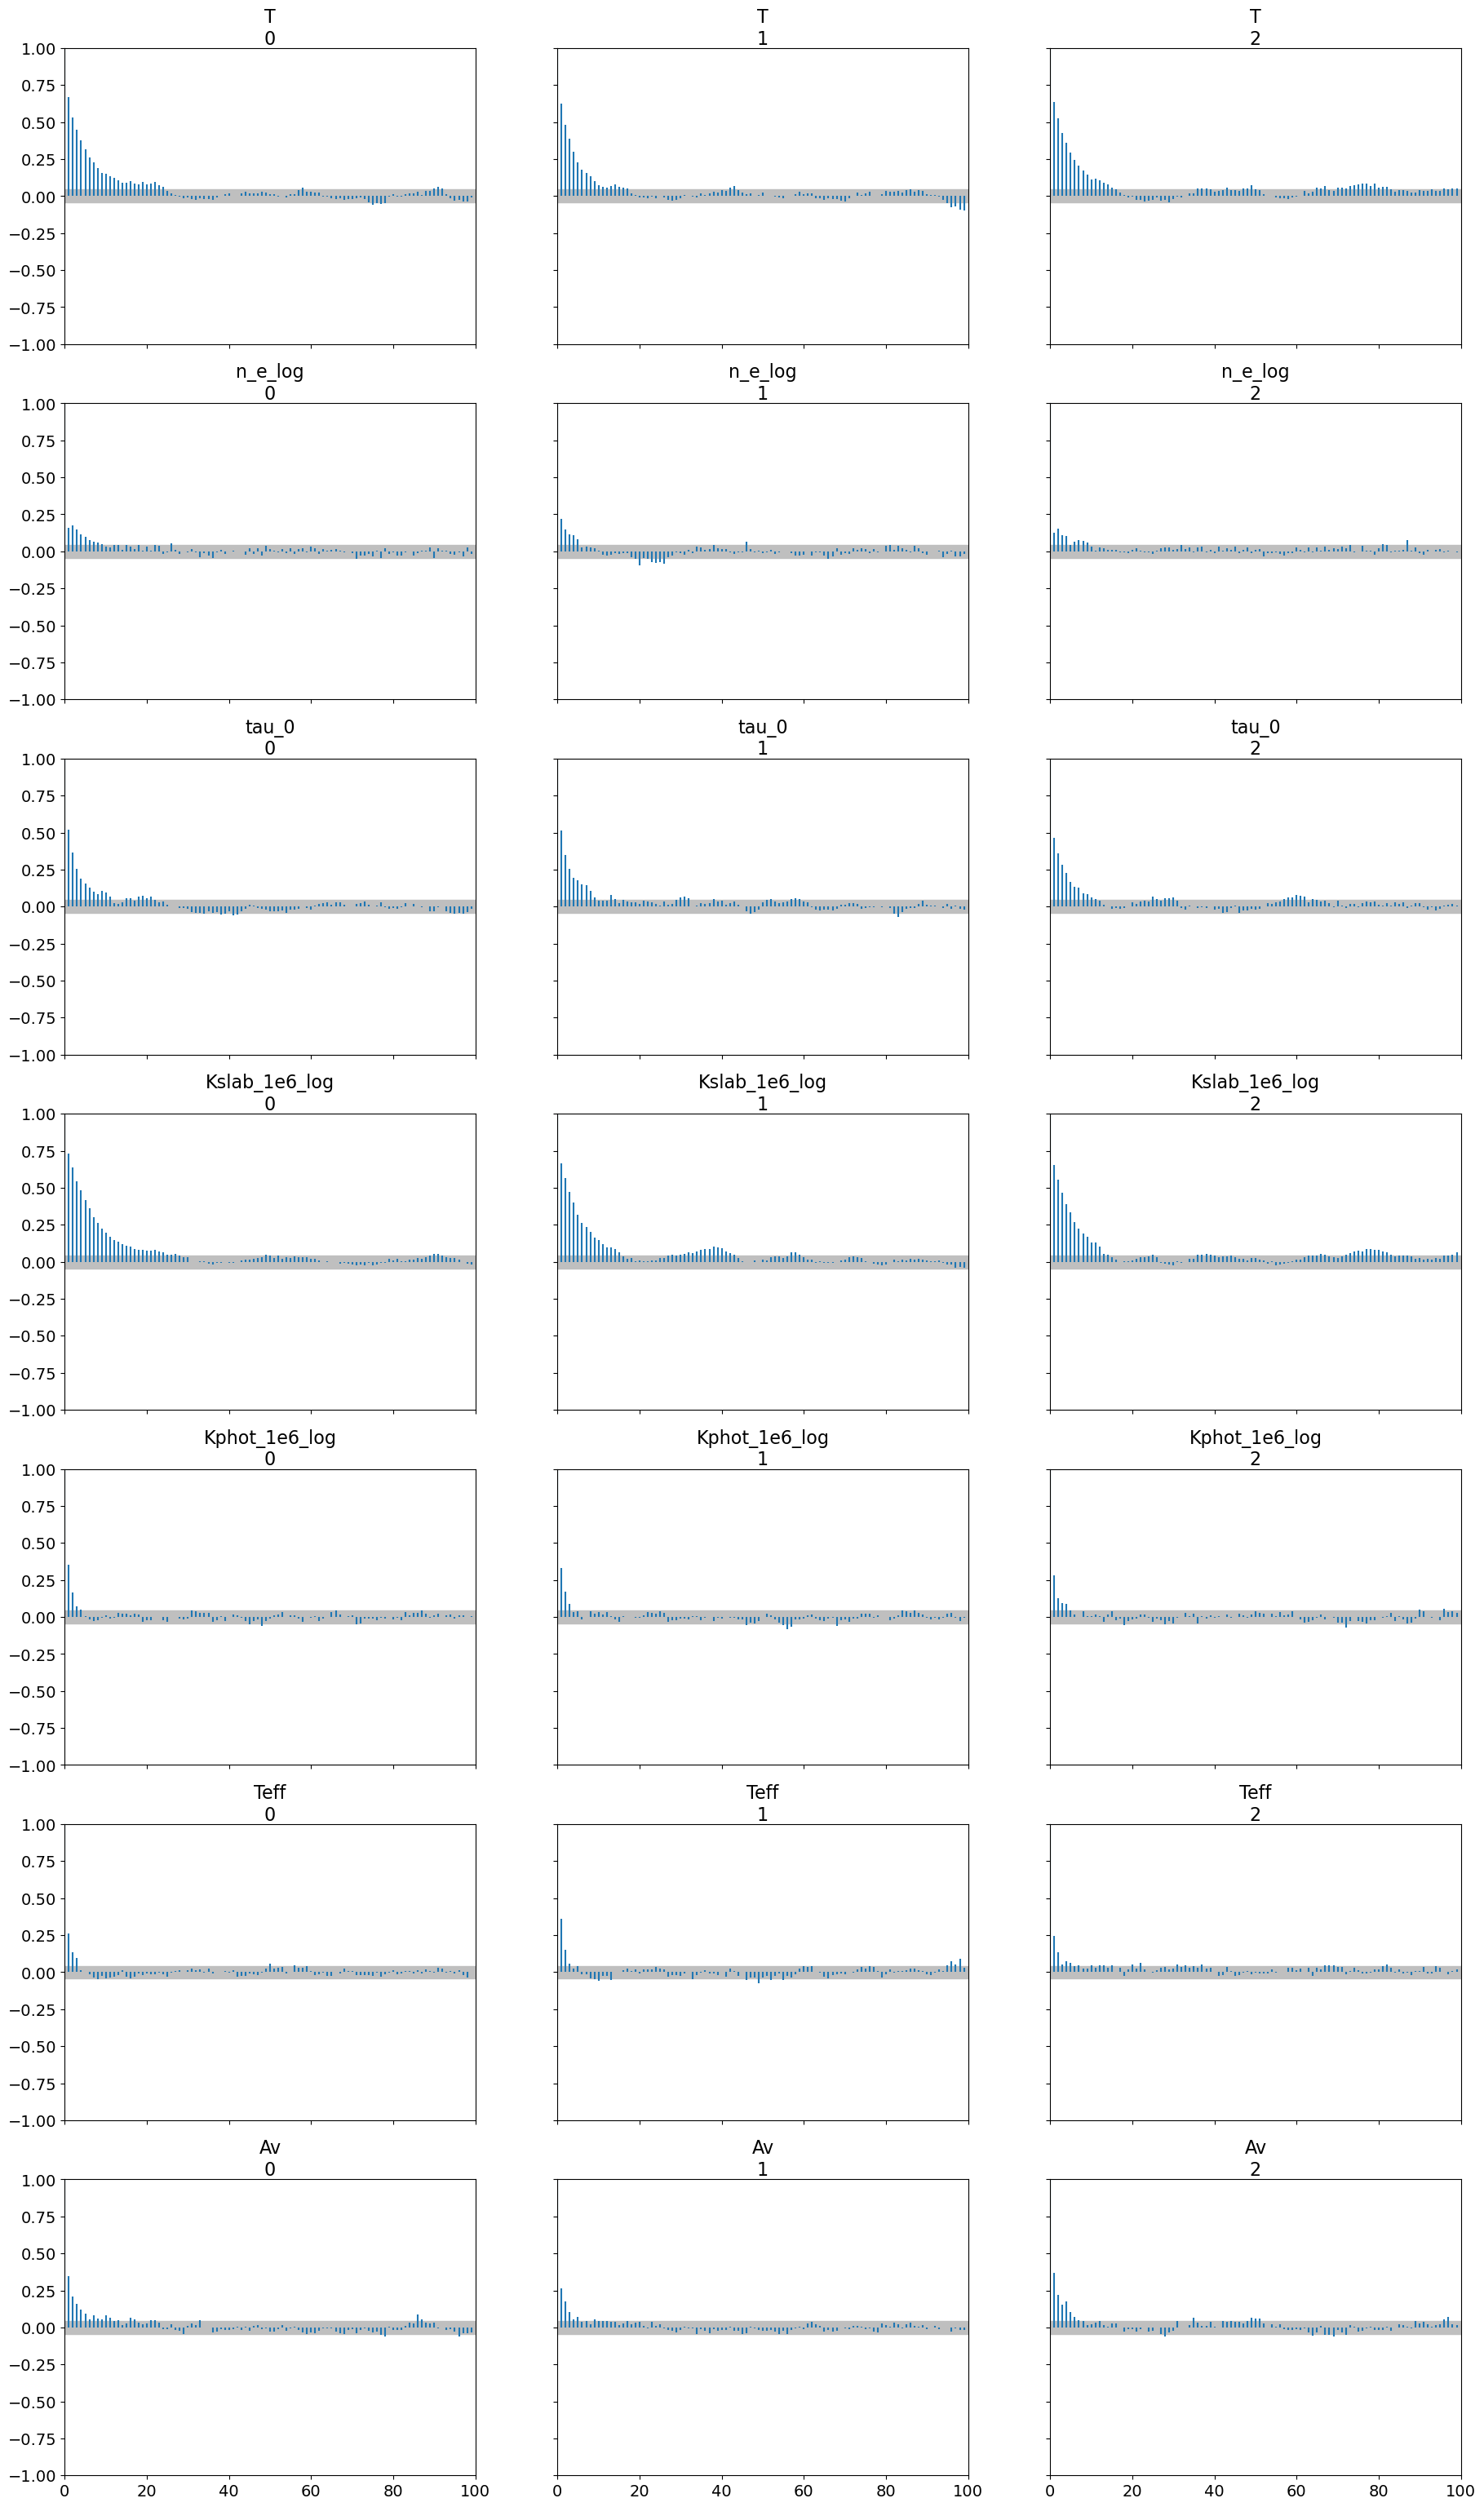

In [14]:
arviz.plot_autocorr(trace.sel(chain=[0,1,2]), var_names= ['T', 'n_e_log', 'tau_0', 'Kslab_1e6_log', 'Kphot_1e6_log', 'Teff', 'Av'])

In [15]:
thinning = 20 #for example, use every 20th sample

Finally, we can plot out what the resulting model fit looks like. The rest of the cells in this notebook are dedicated to plotting out the median model fit result for our example YSO. The model written below is the same as in pymc_fitter.py 

In [16]:
c = 2.99792458 * (1e10)
nu = c*(1e8) / def_wave_model
wave_cm = (def_wave_model*(1e-8))
diff = def_wave_model[1]-def_wave_model[0]
wavelength_spacing_model = diff #angstroms
full_wave = wavelength_spacing_model*np.arange((def_wave_data[0]/wavelength_spacing_model-((def_wave_data[0]-500)//wavelength_spacing_model)),(def_wave_data[0]/wavelength_spacing_model-((def_wave_data[0]-25000)//wavelength_spacing_model)))
nu_2 = c*(1e8) / full_wave
wave_cm_2 = (full_wave*(1e-8))
wavelength_micron = full_wave / 10000

h = 6.62607004 * (1e-27)
k_B = 1.38064852 * (1e-16)
nu_0 = 3.28795 * (1e15) #hz -- ionization frequency for hydrogen
mH = 1.6735 * (1e-24)
me = 9.10938356 * (1e-28)
mp = 1.6726219 * (1e-24)
Z_i = 1
lamb_0 = 1.6419 #photodetachment threshold in microns
alpha = 1.439 * (1e4)
lambda_0 = 300e-7 #defined by Manara 2013b
freq_0 = c/lambda_0

#valid 0.182 to 0.3645 um 
Ans_ff_1 = [518.1021,  473.2636, -482.2089 , 115.5291, 0, 0]
Bns_ff_1 = [-734.8667, 1443.4137 , -737.1616,  169.6374, 0, 0]
Cns_ff_1 = [1021.1775, -1977.3395,  1096.8827, -245.6490, 0, 0]
Dns_ff_1 = [-479.0721, 922.3575, -521.1341, 114.2430, 0, 0]
Ens_ff_1 = [93.1373, -178.9275, 101.7963, -21.9972, 0, 0]
Fns_ff_1 = [-6.4285, 12.3600, -7.0571,  1.5097, 0, 0]

#valid > 0.3645 um 
Ans_ff_2 = [0, 2483.3460, -3449.8890, 2200.0400, -696.2710, 88.2830]
Bns_ff_2 = [0, 285.8270, -1158.3820, 2427.7190, -1841.4000, 444.5170]
Cns_ff_2 = [0, -2054.2910, 8746.5230, -13651.1050, 8624.9700, -1863.8640]
Dns_ff_2 = [0, 2827.7760, -11485.6320, 16755.5240, -10051.5300, 2095.2880]
Ens_ff_2 = [0, -1341.5370, 5303.6090, -7510.4940, 4400.0670, -901.7880]
Fns_ff_2 = [0, 208.9520, -812.9390, 1132.7380, -655.0200, 132.9850]

Cns_fb = [152.519, 49.534, -118.858, 92.536, -34.194, 4.982] #valid from 0.125 to 1.6419 um

T = tt.scalar('T')
n_e = tt.scalar('n_e')
tau_0 = tt.scalar('tau_0')
Kslab = tt.scalar('Kslab')
Kphot = tt.scalar('Kphot')
Av = tt.scalar('Av')
Av_grid_uncert = tt.scalar('Av_grid_uncert')
Teff = tt.scalar('Teff')
Teff_grid_uncert = tt.scalar('Teff_grid_uncert')

templates_scaled_shared = tt.as_tensor(np.array(templates_scaled))
template_Teffs_shared = tt.as_tensor(np.array(template_Teffs))
template_Teff_right = (tt.switch((template_Teffs_shared > (Teff+Teff_grid_uncert)), template_Teffs_shared, 0))
template_Teff_right = tt.min(template_Teff_right[template_Teff_right.nonzero()])
template_right = templates_scaled_shared[(tt.eq(template_Teffs_shared, template_Teff_right).nonzero()[0][0])]
template_Teff_left = (tt.switch((template_Teffs_shared <= (Teff+Teff_grid_uncert)), template_Teffs_shared, 0))
template_Teff_left = tt.max(template_Teff_left[template_Teff_left.nonzero()]) 
template_left = templates_scaled_shared[(tt.eq(template_Teffs_shared, template_Teff_left).nonzero()[0][0])]
rightweight = (Teff+Teff_grid_uncert-template_Teff_left)/(template_Teff_right-template_Teff_left)
leftweight = (template_Teff_right-(Teff+Teff_grid_uncert))/(template_Teff_right-template_Teff_left)
my_template = tt.switch(tt.eq(template_Teff_left,(Teff+Teff_grid_uncert)),template_left,(leftweight*template_left + rightweight*template_right))
photosphere = my_template
    
B_out_2 = 2*h*(nu_2**3)*(1/((tt.exp((h*nu_2)/(k_B*T)))-1))/(c**2)
coeff = (2*h*nu_0*(Z_i**2)) / (k_B*T)
m_2 = tt.floor((nu_0*(Z_i**2)/nu_2)**(1/2)+1)
frac1_2 = tt.switch(tt.eq(m_2, 1.0), (nu_2/(nu_0 * (Z_i**2))), 0)
frac1_2 = frac1_2[frac1_2.nonzero()]
frac2_2 = tt.switch(tt.eq(m_2, 2.0), (nu_2/(nu_0 * (Z_i**2))), 0)
frac2_2 = frac2_2[frac2_2.nonzero()]
frac3_2 = tt.switch(tt.eq(m_2, 3.0), (nu_2/(nu_0 * (Z_i**2))), 0)
frac3_2 = frac3_2[frac3_2.nonzero()]
frac4_2 = tt.switch(tt.eq(m_2, 4.0), (nu_2/(nu_0 * (Z_i**2))), 0)
frac4_2 = frac4_2[frac4_2.nonzero()]
frac5_2 = tt.switch(tt.eq(m_2, 5.0), (nu_2/(nu_0 * (Z_i**2))), 0)
frac5_2 = frac5_2[frac5_2.nonzero()]
frac6_2 = tt.switch(tt.eq(m_2, 6.0), (nu_2/(nu_0 * (Z_i**2))), 0)
frac6_2 = frac6_2[frac6_2.nonzero()]
y1_2 = tt.zeros(frac1_2.shape)
y2_2 = tt.zeros(frac2_2.shape)
y3_2 = tt.zeros(frac3_2.shape)
y4_2 = tt.zeros(frac4_2.shape)
y5_2 = tt.zeros(frac5_2.shape)
y6_2 = tt.zeros(frac6_2.shape)
for n in range(1, 20):
    gn = 1 + (0.1728*(frac1_2**(1/3) - (2*(frac1_2**(-2/3))/(n**2)))) - .0496*(frac1_2**(2/3) - (2*(frac1_2**(-1/3))/((3*(n**2)))) + (2*(frac1_2**(-4/3))/((3*(n**4)))))
    exp = (h*nu_0) / ((n**2)*k_B*T)
    y1_2 += (n**-3)*(tt.exp(exp))*gn
for n in range(2, 20):
    gn = 1 + (0.1728*(frac2_2**(1/3) - (2*(frac2_2**(-2/3))/(n**2)))) - .0496*(frac2_2**(2/3) - (2*(frac2_2**(-1/3))/((3*(n**2)))) + (2*(frac2_2**(-4/3))/((3*(n**4)))))
    exp = (h*nu_0) / ((n**2)*k_B*T)
    y2_2 += (n**-3)*(tt.exp(exp))*gn
for n in range(3, 20):
    gn = 1 + (0.1728*(frac3_2**(1/3) - (2*(frac3_2**(-2/3))/(n**2)))) - .0496*(frac3_2**(2/3) - (2*(frac3_2**(-1/3))/((3*(n**2)))) + (2*(frac3_2**(-4/3))/((3*(n**4)))))
    exp = (h*nu_0) / ((n**2)*k_B*T)
    y3_2 += (n**-3)*(tt.exp(exp))*gn    
for n in range(4, 20):
    gn = 1 + (0.1728*(frac4_2**(1/3) - (2*(frac4_2**(-2/3))/(n**2)))) - .0496*(frac4_2**(2/3) - (2*(frac4_2**(-1/3))/((3*(n**2)))) + (2*(frac4_2**(-4/3))/((3*(n**4)))))
    exp = (h*nu_0) / ((n**2)*k_B*T)
    y4_2 += (n**-3)*(tt.exp(exp))*gn 
for n in range(5, 20):
    gn = 1 + (0.1728*(frac5_2**(1/3) - (2*(frac5_2**(-2/3))/(n**2)))) - .0496*(frac5_2**(2/3) - (2*(frac5_2**(-1/3))/((3*(n**2)))) + (2*(frac5_2**(-4/3))/((3*(n**4)))))
    exp = (h*nu_0) / ((n**2)*k_B*T)
    y5_2 += (n**-3)*(tt.exp(exp))*gn 
for n in range(6, 20):
    gn = 1 + (0.1728*(frac6_2**(1/3) - (2*(frac6_2**(-2/3))/(n**2)))) - .0496*(frac6_2**(2/3) - (2*(frac6_2**(-1/3))/((3*(n**2)))) + (2*(frac6_2**(-4/3))/((3*(n**4)))))
    exp = (h*nu_0) / ((n**2)*k_B*T)
    y6_2 += (n**-3)*(tt.exp(exp))*gn 
g_fb_out_2=(tt.concatenate((y1_2,y2_2,y3_2,y4_2,y5_2,y6_2)))*coeff
g_ff_out_2 = 1 + (0.1728* ((nu_2/(nu_0*(Z_i**2)))**(1/3)) *(1+(2*k_B*T/(h*nu_2)))) - (.0496*((nu_2/(nu_0*(Z_i**2)))**(2/3)) * (1+(2*k_B*T/(3*h*nu_2)) +((4/3)*((k_B*T/(h*nu_2))**2)) ))
j_out_2 = 5.44*(1e-39)*(tt.exp((-h*nu_2)/(k_B*T)))*(T**(-1/2)) * (n_e**2) * (g_ff_out_2 + g_fb_out_2)
coeff = (2*h*nu_0*(Z_i**2)) / (k_B*T)
B_Lslab_out = 2*h*(freq_0**3)*(1/((tt.exp((h*freq_0)/(k_B*T)))-1))/(c**2)
g_ff_Lslab_out = 1 + (0.1728* ((freq_0/(nu_0*(Z_i**2)))**(1/3)) *(1+(2*k_B*T/(h*freq_0)))) - (.0496*((freq_0/(nu_0*(Z_i**2)))**(2/3)) * (1+(2*k_B*T/(3*h*freq_0)) +((4/3)*((k_B*T/(h*freq_0))**2)) ))
g_fb_Lslab_out = 0
for n in range(2, 20):
    gn = 1 + (0.1728*((freq_0/(nu_0 * (Z_i**2)))**(1/3) - (2*((freq_0/(nu_0 * (Z_i**2)))**(-2/3))/(n**2)))) - .0496*((freq_0/(nu_0 * (Z_i**2)))**(2/3) - (2*((freq_0/(nu_0 * (Z_i**2)))**(-1/3))/((3*(n**2)))) + (2*((freq_0/(nu_0 * (Z_i**2)))**(-4/3))/((3*(n**4)))))
    g_fb_Lslab_out += (n**-3)*(tt.exp((h*nu_0) / ((n**2)*k_B*T)))*gn
g_fb_Lslab_out *= coeff 
j_Lslab_out = 5.44*(1e-39)*(tt.exp((-h*freq_0)/(k_B*T)))*(T**(-1/2)) * (n_e**2) * (g_ff_Lslab_out + g_fb_Lslab_out)
Lslab_out = tau_0 * B_Lslab_out / j_Lslab_out
tau_H_out_2 = j_out_2 * Lslab_out / B_out_2 
lamb_2 = (c/nu_2) *(1e4)
lamb_2_alt = tt.switch(lamb_2 < lamb_0, lamb_2, lamb_0)
f_out_2 = tt.zeros(len(nu_2))
for n in range(0,6):
    Cn = Cns_fb[n]
    f_out_2+= tt.switch(lamb_2 < lamb_0, Cn * ((1/lamb_2_alt) - (1/lamb_0))**((n)/2),0)
sigma_out_2 = tt.switch(lamb_2 < lamb_0, (1e-18)*(lamb_2_alt**3)*(((1/lamb_2_alt) - (1/lamb_0))**(3/2))*(f_out_2),0)
k_fb__out_2 = 0.750*(T**(-5/2))*(tt.exp(alpha/(lamb_0*T))) * (1-(tt.exp(-alpha/(lamb_2*T)))) * sigma_out_2
lamb1_2 = tt.switch((lamb_2 <= 0.182), lamb_2, 0)
lamb1_2 = lamb1_2[lamb1_2.nonzero()]  
lamb2_2 = tt.switch((lamb_2 < 0.3645), lamb_2, 0)
lamb2_2 = tt.switch((lamb2_2 > 0.182), lamb2_2, 0)
lamb2_2 = lamb2_2[lamb2_2.nonzero()] 
lamb3_2 = tt.switch((lamb_2 >= 0.3645), lamb_2, 0)
lamb3_2 = lamb3_2[lamb3_2.nonzero()] 
y1_2 = tt.zeros(lamb1_2.shape)
y2_2 = tt.zeros(lamb2_2.shape)
y3_2 = tt.zeros(lamb3_2.shape)
for n in range(0,6):
    y2_2+= ((5040/T)**((n+1)/2)) * (((lamb2_2**2)*Ans_ff_1[n]) + Bns_ff_1[n] + (Cns_ff_1[n]/lamb2_2) + (Dns_ff_1[n]/(lamb2_2**2)) + (Ens_ff_1[n]/(lamb2_2**3)) + (Fns_ff_1[n]/(lamb2_2**4)))
    y3_2+= ((5040/T)**((n+1)/2)) * (((lamb3_2**2)*Ans_ff_2[n]) + Bns_ff_2[n] + (Cns_ff_2[n]/lamb3_2) + (Dns_ff_2[n]/(lamb3_2**2)) + (Ens_ff_2[n]/(lamb3_2**3)) + (Fns_ff_2[n]/(lamb3_2**4)))
k_ff__out_2 = (tt.concatenate((y1_2, y2_2, y3_2)))*(1e-29)
coeff2 = ((h**3)/((2*math.pi*me*k_B)**(3/2)))
n_H_out=0
for n in range(1,20):
    n_H_out += (n**2)*(tt.exp(h*nu_0/((n**2)*k_B*T)))
n_H_out*= coeff2*(T**(-3/2))*(n_e**2)
k_H__out_2 = (k_fb__out_2 + k_ff__out_2)*n_e*n_H_out*k_B*T
tau_H__out_2 = k_H__out_2 * Lslab_out
I_H_out_2 = tau_H_out_2 * B_out_2 * ((1-(tt.exp(-tau_H_out_2)))/tau_H_out_2)
I_H__out_2 = tau_H__out_2 * B_out_2 * ((1-(tt.exp(-tau_H__out_2)))/tau_H__out_2)
tau_total_2 = tau_H_out_2 + tau_H__out_2
beta_tau_total_out_2 = (1-(tt.exp(-tau_total_2)))/tau_total_2
I_both_out_2 = tau_total_2 * B_out_2 * beta_tau_total_out_2

generate_slab_out_2 = (c*I_both_out_2/((wave_cm_2)**2)) * (1e-8)
slab_shortened = generate_slab_out_2[(tt.eq(nu_2, nu[0])).nonzero()[0][0]:((tt.eq(nu_2, nu[-1])).nonzero()[0][0]+int(diff/wavelength_spacing_model)):int(diff/wavelength_spacing_model)]
generate_slab = pytensor.function([T, n_e, tau_0], slab_shortened)

#reddening
wavelength_micron = def_wave_model / 10000
wave_inv = (wavelength_micron**-1)
x_OPT = wave_inv-1.82
a_OPT = 1 + (0.17699*x_OPT) - (0.50447*(x_OPT**2)) - (0.02427*(x_OPT**3)) + (0.72085*(x_OPT**4)) + (0.01979*(x_OPT**5)) - (0.77530*(x_OPT**6)) + (.32999*(x_OPT**7))
b_OPT = (1.41338*x_OPT) + (2.28305*(x_OPT**2)) + (1.07233*(x_OPT**3)) - (5.38434*(x_OPT**4)) - (0.62251*(x_OPT**5)) + (5.30260*(x_OPT**6)) - (2.09002*(x_OPT**7))
z_OPT = a_OPT + (b_OPT/Rv)
x_IR = wave_inv
a_IR = 0.574*(x_IR**1.61)
b_IR = -0.527*(x_IR**1.61)
z_IR = a_IR + (b_IR/Rv)
A_specific  = (Av)* tt.switch(((wavelength_micron**-1) >= 1.1), z_OPT, z_IR)
A_specific_2  = (Av+Av_grid_uncert)* tt.switch(((wavelength_micron**-1) >= 1.1), z_OPT, z_IR)   
reddened_slab = (slab_shortened * (10 ** (-0.4 * A_specific_2)))
reddened_photosphere = (photosphere * (10 ** (-0.4 * A_specific)))

model = reddened_slab*Kslab + reddened_photosphere*Kphot
model_creation = pytensor.function([T, n_e, tau_0, Kslab, Kphot, Av, Av_grid_uncert, Teff, Teff_grid_uncert], [reddened_slab*Kslab, reddened_photosphere*Kphot, model])

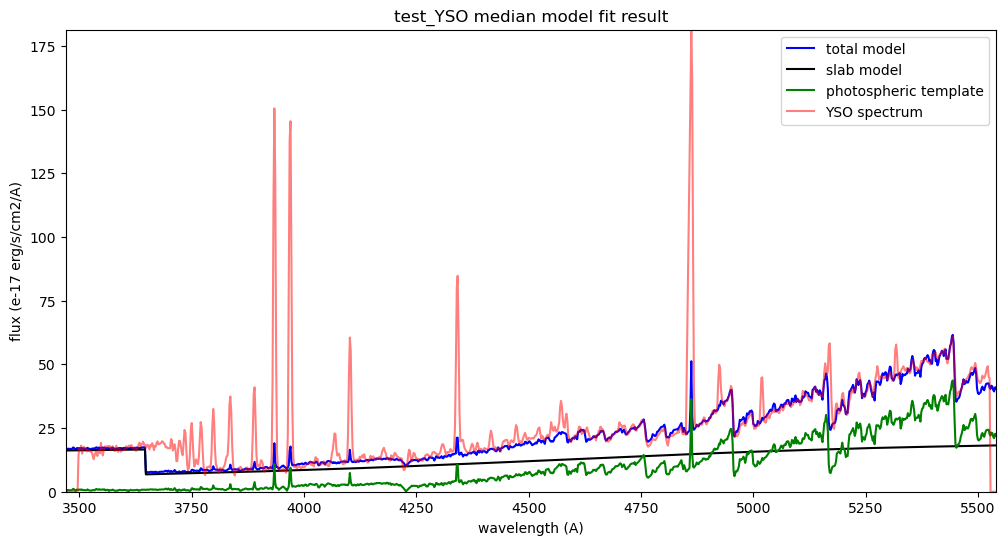

In [17]:
T_array = trace.posterior['T'].values[::thinning][0]
n_e_log_array = trace.posterior['n_e_log'].values[::thinning][0]
tau_0_array = trace.posterior['tau_0'].values[::thinning][0]
Kslab_1e6_array = trace.posterior['Kslab_1e6'].values[::thinning][0]
Kphot_1e6_array = trace.posterior['Kphot_1e6'].values[::thinning][0]
Av_array = trace.posterior['Av'].values[::thinning][0]
Av_grid_uncert_array = trace.posterior['Av_grid_uncert'].values[::thinning][0]
Teff_array = trace.posterior['Teff'].values[::thinning][0]
Teff_grid_uncert_array = trace.posterior['Teff_grid_uncert'].values[::thinning][0]
Lacc_log_array = trace.posterior['Lacc_log_traced'].values[::thinning][0]
L_log_array = trace.posterior['L_log_traced'].values[::thinning][0]
distance_array = trace.posterior['distance'].values[::thinning][0]

model_stack = []
model_slab_stack = []
model_phot_stack = []
for x in range(0, len(T_array)):
    T_current = T_array[x]
    n_e_current = 10**(n_e_log_array[x])
    tau_0_current = tau_0_array[x]
    Kslab_current = Kslab_1e6_array[x]/1e6
    Kphot_current = Kphot_1e6_array[x]/1e6
    Av_current = Av_array[x]
    Av_grid_uncert_current = Av_grid_uncert_array[x]
    #Teff_current = Teff_array[x]
    #Teff_grid_uncert_current = Teff_grid_uncert_array[x]
    Teff_current = Teff_array[x] + Teff_grid_uncert_array[x]
    #model_current = model_creation(T_current, n_e_current, tau_0_current, Kslab_current, Kphot_current, Av_current, Av_grid_uncert_current, Teff_current, Teff_grid_uncert_current)
    model_current = generate_model_output(T_current, n_e_current, tau_0_current, Kslab_current, Kphot_current, Av_current, Av_grid_uncert_current, Teff_current)
    model_stack.append(model_current[2])
    model_slab_stack.append(model_current[0])
    model_phot_stack.append(model_current[1])
model_stack = np.array(model_stack)
model_slab_stack = np.array(model_slab_stack)
model_phot_stack = np.array(model_phot_stack)
medians = []
medians_slab = []
medians_phot = []
for w in range(0, len(def_wave_model)):
    sliced = model_stack[:,w]
    sliced_slab = model_slab_stack[:,w]
    sliced_phot = model_phot_stack[:,w]
    medians.append(np.median(sliced))
    medians_slab.append(np.median(sliced_slab))
    medians_phot.append(np.median(sliced_phot))
    
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(def_wave_model, medians, c = 'blue', label = 'total model')
ax.plot(def_wave_model, medians_slab, c = 'black', label = 'slab model')
ax.plot(def_wave_model, medians_phot, c = 'green', label = 'photospheric template')
ax.plot(def_wave_data, YSO, c = 'red', alpha = 0.5, label = 'YSO spectrum')
ax.set_xlim(def_wave_data[0], def_wave_data[-1])
ax.set_ylim(0, 1*np.max(YSO))
ax.legend()
ax.set_xlabel('wavelength (A)')
ax.set_ylabel('flux (e-17 erg/s/cm2/A)')
ax.set_title(name+' median model fit result')
fig.savefig(name+ '_median_model_plot')
fig.show()